# 問題：偽札検知（SVM）
## 1.データの読み込み

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
names = ['x1', 'x2', 'x3', 'x4', 'y']
df_train = pd.read_csv('./data_banknote_authentication.txt', header=None, names=names)
df_train[:10]

,x1,x2,x3,x4,y
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


## 2.データの観察

In [2]:
df_train.describe()

,x1,x2,x3,x4,y
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


4列目の値は平均が0.5なので偽札と本物が半分ずつくらいだと思われる

In [3]:
df_train.isnull().sum()

x1    0
x2    0
x3    0
x4    0
y     0
dtype: int64

以上より、欠損値はなし

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000219EC44D940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000219EC9BC470>]], dtype=object)

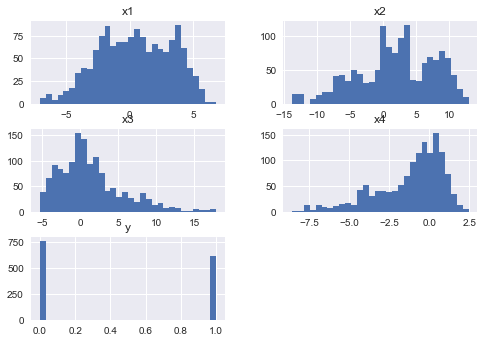

In [4]:
df_train.hist(bins=30)

とりあえずヒストグラムを確認。

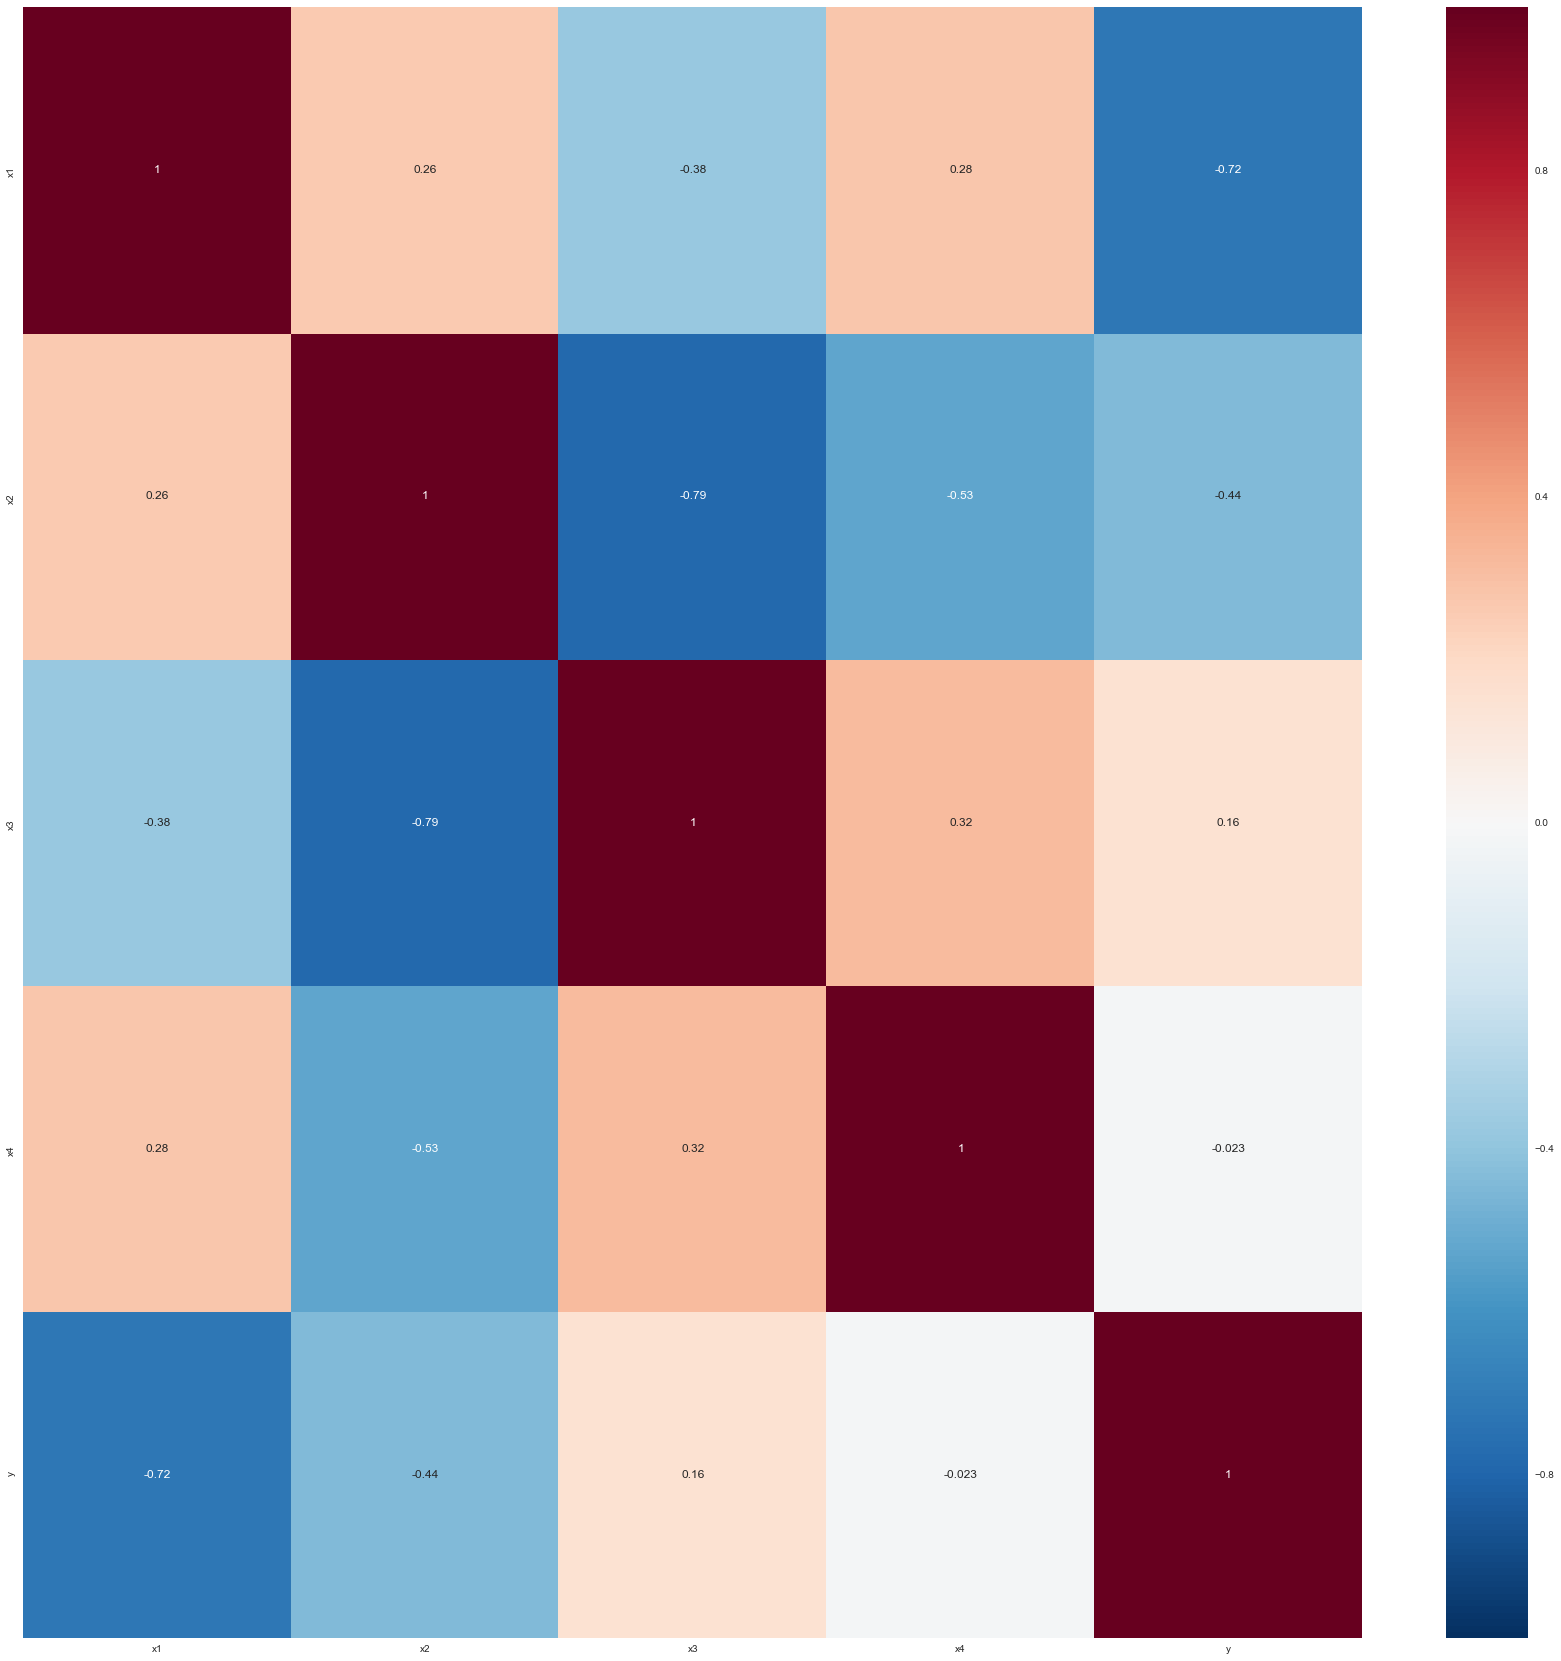

In [5]:
#相関係数行列の可視化
# 行１列１、縦横30インチの箱を用意する
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
# seabornのheatmapを作成
# df_train.corr(): トレーニングデータの相関係数
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

目的変数(4列目)と相関係数が一番高いのは0列目の0.72、これくらいの大きさなら線形非線形どちらでも取れそうな気がする。。。

## 3.データの整形
欠損値なし、カテゴリ属性なしのため何もしない

## 4.Support Vector分類器に訓練データを登録する
テストデータが300件になるように調整する

In [6]:
if "y" in df_train.columns:
    y = df_train.y
    del df_train['y']
X = df_train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.218, random_state=0)

print('There are {} samples in the training set and {} samples in the test set'.format(
X_train.shape[0], X_test.shape[0]))

There are 1072 samples in the training set and 300 samples in the test set


In [7]:
# For many machine learning algorithms, it is important to scale the data. Let's do that now using sklearn.
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('After standardizing our features, the first 5 rows of our data now look like this:\n')
print(pd.DataFrame(X_train_std, columns=df_train.columns).head())

After standardizing our features, the first 5 rows of our data now look like this:

         x1        x2        x3        x4
0  0.843021  1.291533 -1.102908  0.060273
1 -1.532910  0.368641 -0.412584 -1.302694
2  0.853525  0.864928 -0.514615  0.795671
3 -0.856809  0.337355 -0.477257  0.000816
4 -0.970012 -1.154360  1.229770  0.534850


## 5.データ量, 特徴により線形分類か非線形分類かを決定
## 6.Support Vector分類器ハイパラメータを決定する
## 7.訓練データを用いてSupport Vector分類器の学習モデルを作成する

In [8]:
# グリッドサーチで線形、非線形か判断してもらって、ハイパーパラメータを決定する
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {'kernel':['rbf', 'linear'] ,'C': [10**i for i in range(-3, 3)],  'gamma' : [2**i for i in range(-5,5)]}
grid = GridSearchCV(SVC(), params, cv=5)
search_result = grid.fit(X_train_std, y_train)
best = search_result.best_estimator_
print ("ベストモデル:", best)

ベストモデル: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.25, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## 8.学習モデルのスコア値（正解率など）を算出する。

In [9]:
print('The accuracy of the svm classifier on training data is {:.2f} out of 1'.format(best.score(X_train_std, y_train)))

The accuracy of the svm classifier on training data is 1.00 out of 1


# 9.学習後モデルに評価データを適用し目的変数の予測を行う

In [10]:
print('The accuracy of the svm classifier on test data is {:.2f} out of 1'.format(best.score(X_test_std, y_test)))

The accuracy of the svm classifier on test data is 1.00 out of 1


UCIからデータとってきてから問題を解くのにかかった時間：75分  
線形か非線形かで悩んだが、サンプルコードを見てグリッドサーチで判断させればいいということが分かった。  
ただ、アルゴリズムチャートシートでも線形か非線形かで分岐しているので明確な基準があれば示しておいた方が良いと思った。